# Lineup Progression Heatmaps (Top 5 by Minutes per Interval)

This notebook visualizes lineup progression across intervals from `progression.csv`.

**Metrics:** minutes, rel_net_rtg, rel_PM_p40, off_rtg, def_rtg

**Lineups included:** union of the **top 5 lineups by minutes in each interval** (then sorted by total minutes across all intervals).


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)


In [12]:
# ---- Load data ----
# Option A: if lineup_prog already exists in your kernel, we use it.
# Option B: otherwise we load progression.csv from disk.

lineup_prog = pd.read_csv('progression.csv')

# Basic checks
req = ['interval_num','lineup','minutes','rel_net_rtg','rel_PM_p40','off_rtg','def_rtg']
missing = [c for c in req if c not in lineup_prog.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}\nColumns present: {list(lineup_prog.columns)}")

# Make sure interval_num is clean / sorted
lineup_prog['interval_num'] = pd.to_numeric(lineup_prog['interval_num'], errors='coerce').astype('Int64')
lineup_prog = lineup_prog.dropna(subset=['interval_num']).copy()
lineup_prog['interval_num'] = lineup_prog['interval_num'].astype(int)

lineup_prog.head()

,interval_num,interval_len,lineup,minutes,rel_PM_p40,PM_p40,o_poss,d_poss,plus_minus,net_rtg,off_rtg,def_rtg,poss_total,rel_net_rtg,team_minutes,team_plus_minus,team_pts_for,team_pts_against,team_o_poss,team_d_poss,team_poss_total,team_off_rtg,team_def_rtg,team_net_rtg,team_PM_p40,interval_start,interval_end,pts_for,pts_against,net_pts,o_eFG%,d_eFG%,o_TOV%,d_TOV%,o_orbR,d_orbR,o_ftaR,d_ftaR,rel_off_rtg,rel_def_rtg
0,1,3,JL-AM-IK-MH-CH,21.567,-3.231,-5.564,39.055,34.73,-3,-16.929,66.573,83.501,73.785,-13.390,120.0,-7.0,200.0,207.0,205.955,205.67,411.625,97.109,100.647,-3.538,-2.333,241213,241221,26,29,-3,0.276,0.420,0.230,0.173,0.077,0.029,0.414,0.480,-30.536,-17.145
1,1,3,JL-AM-AC-MH-CH,9.390,-10.446,-12.780,16.190,17.73,-3,-7.800,105.003,112.803,33.920,-4.262,120.0,-7.0,200.0,207.0,205.955,205.67,411.625,97.109,100.647,-3.538,-2.333,241213,241221,17,20,-3,0.429,0.650,0.185,0.226,0.247,0.113,0.429,1.200,7.894,12.156
2,1,3,JL-AC-IK-MH-CH,9.300,2.333,0.000,14.920,15.92,0,8.420,134.048,125.628,30.840,11.958,120.0,-7.0,200.0,207.0,205.955,205.67,411.625,97.109,100.647,-3.538,-2.333,241213,241221,20,20,0,0.406,0.531,0.000,0.188,0.268,0.251,0.500,0.188,36.940,24.981
3,1,3,AM-AC-ZO-MH-CH,8.100,-27.296,-29.630,10.790,14.59,-6,-21.813,74.143,95.956,25.380,-18.275,120.0,-7.0,200.0,207.0,205.955,205.67,411.625,97.109,100.647,-3.538,-2.333,241213,241221,8,14,-6,0.333,0.429,0.185,0.206,0.278,0.206,0.000,0.143,-22.966,-4.691
4,1,3,AC-IK-ZO-MH-CH,6.183,28.209,25.876,10.930,10.86,4,36.125,109.790,73.665,21.790,39.663,120.0,-7.0,200.0,207.0,205.955,205.67,411.625,97.109,100.647,-3.538,-2.333,241213,241221,12,8,4,0.545,0.667,0.091,0.645,0.091,0.184,0.000,0.000,12.681,-26.982


In [16]:
def get_top_lineups_union(df: pd.DataFrame, top_n: int = 5) -> list:
    """Union of top N lineups by minutes within each interval."""
    top_sets = []
    for interval, g in df.groupby('interval_num'):
        top = g.sort_values('minutes', ascending=False).head(top_n)['lineup'].tolist()
        top_sets.extend(top)
    # preserve uniqueness while keeping order of first appearance
    seen = set()
    out = []
    for lu in top_sets:
        if lu not in seen:
            seen.add(lu)
            out.append(lu)
    return out


def make_lineup_label_map(df: pd.DataFrame, lineups: list) -> dict:
    """Map lineup -> pretty label with TOTAL minutes across all intervals."""
    mins = df.groupby('lineup')['minutes'].sum()
    label_map = {}
    for lu in lineups:
        total_m = float(mins.get(lu, 0.0))
        pretty = '-'.join([p.upper() for p in str(lu).split('-')])
        label_map[lu] = f"{pretty}-({total_m:.1f})"
    return label_map


def pivot_metric(df: pd.DataFrame, metric: str, lineups_sorted: list, label_map: dict) -> pd.DataFrame:
    """Pivot: rows=lineup_label, cols=interval_num, values=metric."""
    sub = df[df['lineup'].isin(lineups_sorted)].copy()
    sub['lineup_label'] = sub['lineup'].map(label_map)
    piv = sub.pivot(index='lineup_label', columns='interval_num', values=metric)
    # Keep columns sorted by interval
    piv = piv.reindex(sorted(piv.columns), axis=1)
    # Enforce row order: sorted by TOTAL minutes (lineups_sorted)
    row_order = [label_map[lu] for lu in lineups_sorted]
    piv = piv.reindex(row_order, axis=0)
    return piv


def heatmap_matplotlib(data: pd.DataFrame, title: str, cbar_label: str, fmt: str = '.2f', center: float | None = None, cmap: str = 'RdYlGn'):
    """Simple annotated heatmap using matplotlib (no seaborn)."""
    arr = data.to_numpy(dtype=float)

    plt.figure(figsize=(max(8, 1.6 * (data.shape[1] + 1)), max(5, 0.6 * (data.shape[0] + 2))))

    if center is None:
        im = plt.imshow(arr, aspect='auto', cmap=cmap)
    else:
        vmin = np.nanmin(arr)
        vmax = np.nanmax(arr)
        norm = TwoSlopeNorm(vmin=vmin, vcenter=center, vmax=vmax)
        im = plt.imshow(arr, aspect='auto', cmap=cmap, norm=norm)

    plt.title(title, pad=16)
    plt.xlabel('Interval')
    plt.ylabel('Lineup (Total Minutes)')

    plt.xticks(ticks=np.arange(data.shape[1]), labels=[str(c) for c in data.columns])
    plt.yticks(ticks=np.arange(data.shape[0]), labels=data.index)

    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            val = arr[i, j]
            label = '' if np.isnan(val) else format(val, fmt)
            plt.text(j, i, label, ha='center', va='center', fontsize=9)

    cbar = plt.colorbar(im)
    cbar.set_label(cbar_label)
    plt.tight_layout()
    plt.show()


In [19]:
# ---- Select top 5 by minutes in each interval (union) ----
top_lineups = get_top_lineups_union(lineup_prog, top_n=4)

# Sort these lineups by TOTAL minutes across all intervals
total_minutes = lineup_prog.groupby('lineup')['minutes'].sum().loc[top_lineups].sort_values(ascending=False)
top_lineups_sorted = total_minutes.index.tolist()

label_map = make_lineup_label_map(lineup_prog, top_lineups_sorted)

print('Lineups included (sorted by total minutes):')
for lu in top_lineups_sorted:
    print('  ', label_map[lu])


Lineups included (sorted by total minutes):
   JL-AM-IK-MH-CH-(62.7)
   JL-AM-IK-MH-PR-(22.2)
   JL-AM-AC-MH-CH-(20.8)
   AM-AC-ZO-MH-PR-(16.8)
   AM-AC-ZO-MH-CH-(16.8)
   JL-AC-IK-MH-CH-(14.5)
   AM-IK-ZO-MH-PR-(11.1)
   AM-AC-ZO-PR-CH-(7.1)


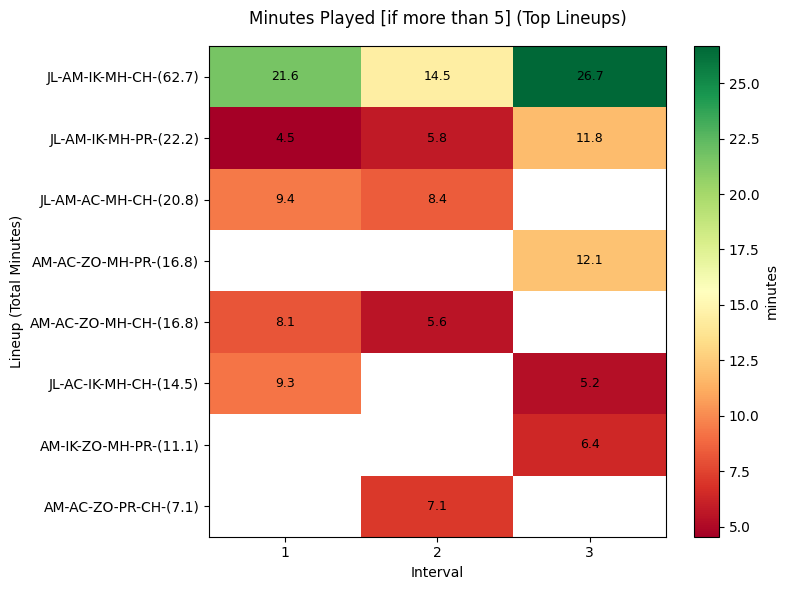

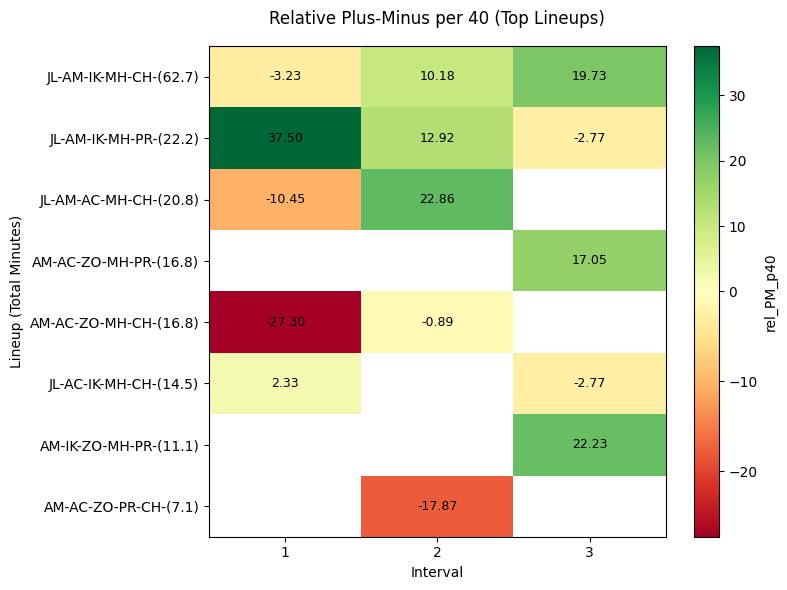

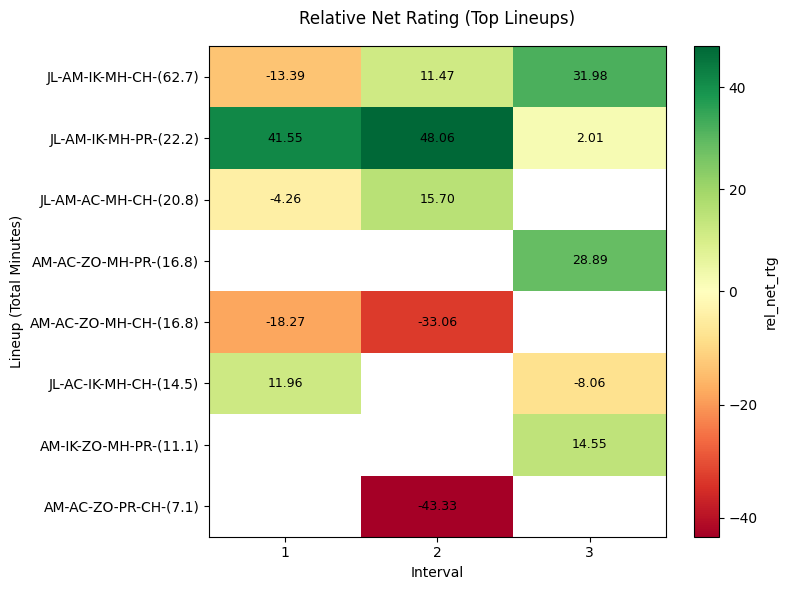

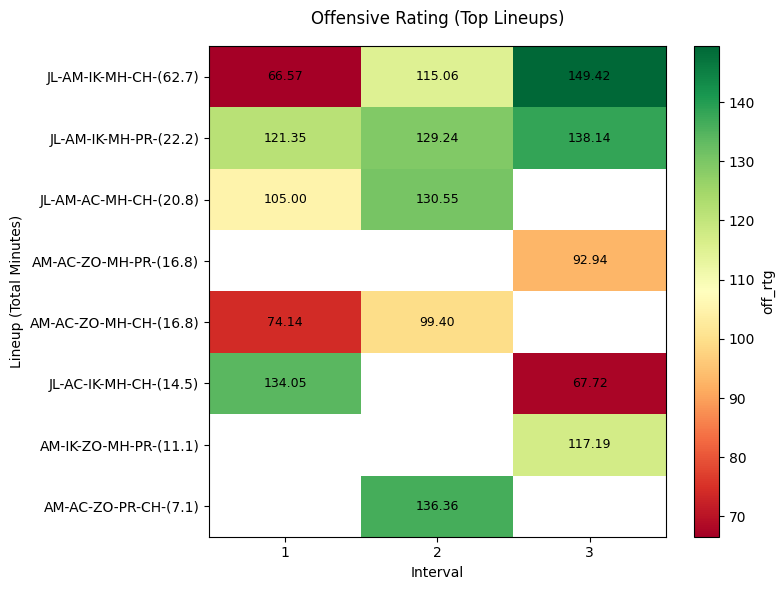

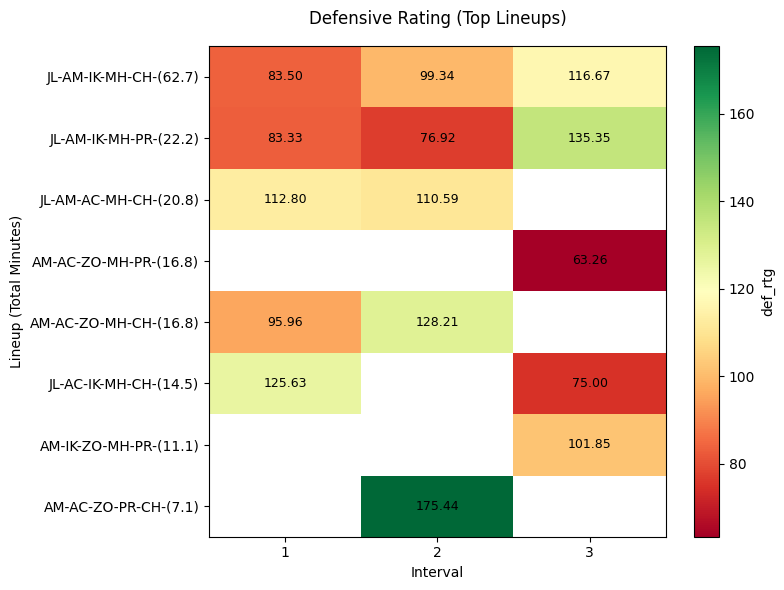

In [27]:
# ---- Heatmaps ----
MIN_MINUTES_CELL = 4.0  # threshold per lineup x interval cell

# 1) Build a minutes pivot that defines what's "valid"
minutes_piv = pivot_metric(lineup_prog, "minutes", top_lineups_sorted, label_map)

# valid mask: True where minutes >= 5
valid_mask = minutes_piv.ge(MIN_MINUTES_CELL)


metrics = [
    ('minutes',      'Minutes Played [if more than 5] (Top Lineups)',                          'minutes',      '.1f', None),
    ('rel_PM_p40',   'Relative Plus-Minus per 40 (Top Lineups)',             'rel_PM_p40',    '.2f', 0.0),
    ('rel_net_rtg',  'Relative Net Rating (Top Lineups)',                    'rel_net_rtg',   '.2f', 0.0),
    ('off_rtg',      'Offensive Rating (Top Lineups)',                       'off_rtg',       '.2f', None),
    ('def_rtg',      'Defensive Rating (Top Lineups)',                       'def_rtg',       '.2f', None),
]

for metric, title, cbar, fmt, center in metrics:
    piv = pivot_metric(lineup_prog, metric, top_lineups_sorted, label_map)

        # align to the same columns/rows as minutes_piv
    piv = piv.reindex(index=minutes_piv.index, columns=minutes_piv.columns)

    # 2) Mask out low-minute cells for all metrics (including minutes if you want)
    piv = piv.where(valid_mask)
    heatmap_matplotlib(piv, title=title, cbar_label=cbar, fmt=fmt, center=center, cmap='RdYlGn')


## Notes / quick tweaks

- If you want **top 5 overall** (not per interval), replace the top-lineup selection with:
  ```python
  mins = lineup_prog.groupby('lineup')['minutes'].sum().nlargest(5)
  top_lineups_sorted = mins.index.tolist()
  label_map = make_lineup_label_map(lineup_prog, top_lineups_sorted)
  ```
- If you want **separate** top-5 lists per interval (not union), we can generate one set of heatmaps per interval.
